In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from common import *

# 1. Load dataset

In [2]:
data_ = pd.read_csv(join(PATH.input, 'train_data.csv'))
data = copy(data_)
data

,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,23:10,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01
4283708,134,222,23:20,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71
4283709,134,222,23:30,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63
4283710,134,222,23:40,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92


In [4]:
dir_path = PATH.input
os.makedirs(dir_path, exist_ok=True)

def save_data(data, name):
    data.to_csv(join(dir_path, f'{name}.csv'), index=False)

# 2. Preprocessing

---
## - Generate time index

In [6]:
def generate_datetime(data, start_date=datetime.datetime(2020, 12, 31)):
    data = copy(data)
    data['Day_tmp'] = (start_date + pd.to_timedelta(data['Day'], unit='day')).astype(str)
    data['Date'] = pd.to_datetime(data.apply(lambda row: f"{row['Day_tmp']} {row['Tmstamp']}:00", axis='columns'))
    for turbID in tqdm(data['TurbID'].unique()):
        d = data[data['TurbID'] == turbID]
        assert d['Date'].is_monotonic_increasing, "Data should be sorted"
        data.loc[data['TurbID'] == turbID, 'Time'] = 1 + np.arange(len(d))
    data.drop(columns=['Day_tmp'], inplace=True)
    data['Time'] = data['Time'].astype(np.int32)
    return data.reset_index(drop=True)

def plot_ts_features(data, idxs_TurbID=[1, 134], cols_except=['Day', 'Time'], figsize=(40, 10)):
    if isinstance(idxs_TurbID, int):
        idxs_TurbID = [idxs_TurbID]
    for turbID in idxs_TurbID:
        d = data.query(f"TurbID == {turbID}").set_index('Date')
        d[d.columns.drop(['TurbID'] + cols_except)].plot(subplots=True, figsize=figsize, title=f"TurbID: {turbID}")
        plt.show()

In [7]:
%%time

data1 = generate_datetime(data)
check_nan(data1, "After generate time")
data1

100%|██████████| 134/134 [00:01<00:00, 77.02it/s]


* Data name: After generate time
  - Number of data: 4283712
  - Number of nan rows: 48605
CPU times: user 51.7 s, sys: 1.44 s, total: 53.1 s
Wall time: 50.3 s


,TurbID,Day,Tmstamp,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Date,Time
0,1,1,00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021-01-01 00:00:00,1
1,1,1,00:10,6.17,-3.99,30.73,41.80,25.92,1.00,1.00,1.00,-0.25,494.66,2021-01-01 00:10:00,2
2,1,1,00:20,6.27,-2.18,30.60,41.63,20.91,1.00,1.00,1.00,-0.24,509.76,2021-01-01 00:20:00,3
3,1,1,00:30,6.42,-0.73,30.52,41.52,20.91,1.00,1.00,1.00,-0.26,542.53,2021-01-01 00:30:00,4
4,1,1,00:40,6.25,0.89,30.49,41.38,20.91,1.00,1.00,1.00,-0.23,509.36,2021-01-01 00:40:00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4283707,134,222,23:10,4.58,-4.41,-0.99,3.37,194.37,0.01,0.01,0.01,-51.69,238.01,2021-08-10 23:10:00,31964
4283708,134,222,23:20,3.74,0.88,-1.05,3.16,187.96,0.01,0.01,0.01,-31.13,172.71,2021-08-10 23:20:00,31965
4283709,134,222,23:30,3.54,0.34,-1.21,2.92,187.96,0.03,0.03,0.03,-58.67,157.63,2021-08-10 23:30:00,31966
4283710,134,222,23:40,4.46,4.13,-1.24,2.81,191.76,0.03,0.03,0.03,-56.66,244.92,2021-08-10 23:40:00,31967


---
## - Handle Error, Anomaly data

In [11]:
def error_handling(data, cols_pos):
    data = copy(data)

    # Non-negative columns
    for col in cols_pos:
        vals      = data[col].value_counts().index
        min_val   = vals[vals > 0][0]
        data[col] = np.maximum(min_val, data[col].values)

    # Clipping
    data['Wdir'] = np.clip(data['Wdir'], -179, 179)
    data['Ndir'] = np.clip(data['Ndir'], -719, 719)
    check_nan(data, "Error handling")
    return data

data2 = error_handling(data1, cols_pos=['Wspd'])

* Data name: Error handling
  - Number of data: 4283712
  - Number of nan rows: 48605


In [12]:
def manual_handling(data):
    def mark(data, col, min_val, max_val):
        data.loc[(data[col] < min_val) | (max_val < data[col]), col] = None

    data = copy(data)
    mark(data, 'Etmp', -20, 80)
    mark(data, 'Itmp', -10, 65)
    
    data.loc[(data['TurbID'] == 2) & (7533 <= data['Time']) & (data['Time'] <= 7899), 'Etmp'] = None
    data.loc[(data['TurbID'] == 2) & (24408 <= data['Time']) & (data['Time'] <= 24414), 'Etmp'] = None
    data.loc[(data['TurbID'] == 2) & (26562 <= data['Time']) & (data['Time'] <= 26575), 'Etmp'] = None

    return data

data3 = manual_handling(data2)

In [13]:
def outlier_handler(data, columns, window_length=21, polyorder=3, verbose=False, smooth=False, fill=True):
    data = data.copy()
    window_size = 2

    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        for i in data_tid['Day'].unique():
            temp = data_tid[(data_tid['Day'] >= i) & (data_tid['Day'] <= i + window_size - 1)].copy()
            if verbose:
                print('Day ', i)
            temp = drop_outliers(temp, columns, verbose)
            if fill:
                temp = fill_gaps(temp, columns)
            if smooth:
                temp = curve_fit(temp, columns, window_length=window_length, polyorder=polyorder)
            data.loc[temp.index] = temp.values
    return data

data4 = outlier_handler(data3, ['Etmp', 'Itmp'], fill=False)

100%|██████████| 134/134 [05:05<00:00,  2.28s/it]


In [14]:
def find_neighbor(data, col, my_TurbID, plot=False):
    df = pd.DataFrame()
    for turbID in data['TurbID'].unique():
        df[turbID] = data[data['TurbID'] == turbID][col].values
    res = df - df[[my_TurbID]].values
    mae = res.abs().mean()
    rst = mae.drop(my_TurbID).idxmin()
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(40, 5))
        mae.plot.bar(ax=ax1)
        df[[my_TurbID, rst]].plot(ax=ax2)
    return rst


def get_dists_loc():
    from sklearn.metrics.pairwise import euclidean_distances

    loc = pd.read_csv(join(PATH.input, 'turb_location.csv')).set_index('TurbID')
    tids = loc.index
    dists_loc = np.full((len(loc)+1, len(loc)+1), np.inf)
    for i1 in range(len(loc)-1):
        for i2 in range(i1+1, len(loc)):
            t1, t2 = tids[i1], tids[i2]
            dists_loc[i1, i2] = euclidean_distances([loc.loc[t1].values], [loc.loc[t2].values])
    return dists_loc


def greedy_imputing_col(d, col, my_TurbID, dists_loc, k, verbose=False):
    dist = lambda turbID: (d.loc[d['TurbID'] == my_TurbID, col] - d.loc[d['TurbID'] == turbID, col]).abs().mean()
    
    neighbors = [turbID for turbID, dist_loc in sorted(enumerate(dists_loc[my_TurbID], start=1), key=lambda x: x[1])[:k]]
    n_nan_prev = d[d['TurbID'] == my_TurbID][col].isna().sum()

    for turbID in sorted(neighbors, key=dist):
        a = d[d['TurbID'] == my_TurbID][col].values
        b = d[d['TurbID'] == turbID][col].values
        d.loc[d['TurbID'] == my_TurbID, col] = np.where(np.isnan(a) & (~np.isnan(b)), b, a)
    
    n_nan_after = d[d['TurbID'] == my_TurbID][col].isna().sum()
    if verbose and n_nan_after < n_nan_prev:
        print(f"[TurbID {my_TurbID} | {col}] Number of nan: {n_nan_prev} -> {n_nan_after}")
    return n_nan_after < n_nan_prev


def greedy_imputing(data, cols=None, tids=None, k=10, verbose=False):
    data = copy(data)
    dists_loc = get_dists_loc()
    
    if cols is None:
        cols = data.columns
    
    if tids is None:
        tids = data['TurbID'].unique()
        
    for col in tqdm(cols):
        success = {}
        while True:
            for my_TurbID in tids:
                success[my_TurbID] = greedy_imputing_col(data, col, my_TurbID, dists_loc, k, verbose)
            if not any(success.values()) or (k == 134):  # full search needs only one loop
                break
    return data


def impute_data(data, threshold=6 * 12):
    data_imp = pd.DataFrame()
    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        idxs = (data_tid.isna().sum(axis='columns') > 0)
        idxs_nan = idxs[idxs].index
        idxs_removed = []

        if len(idxs_nan) > 0:
            s, e = 0, 1
            while e < len(idxs_nan):
                cur = idxs_nan[s:e]
                if idxs_nan[e] == cur[-1] + 1:
                    e += 1
                else:
                    if len(cur) >= threshold:
                        idxs_removed += list(cur)
                    s = e
                    e = s + 1
            else:
                if len(cur) >= threshold:
                    idxs_removed += list(cur)

        data_tid_imp = data_tid.drop(idxs_removed).bfill().ffill()
        data_imp = data_imp.append(data_tid_imp)

    data_imp = data_imp.ffill()
    check_nan(data_imp, "Imputing")
    return data_imp.reset_index(drop=True)


data5_gi = greedy_imputing(data4, cols=data4.columns.drop(['TurbID', 'Day', 'Tmstamp', 'Date', 'Time']), tids=[67, 38, 121, 25, 61, 68, 24])
data5_gi = impute_data(data5_gi)
save_data(data5_gi, 'data5_gi')

100%|██████████| 134/134 [00:11<00:00, 11.42it/s]


* Data name: Imputing
  - Number of data: 4228623
  - Number of nan rows: 0


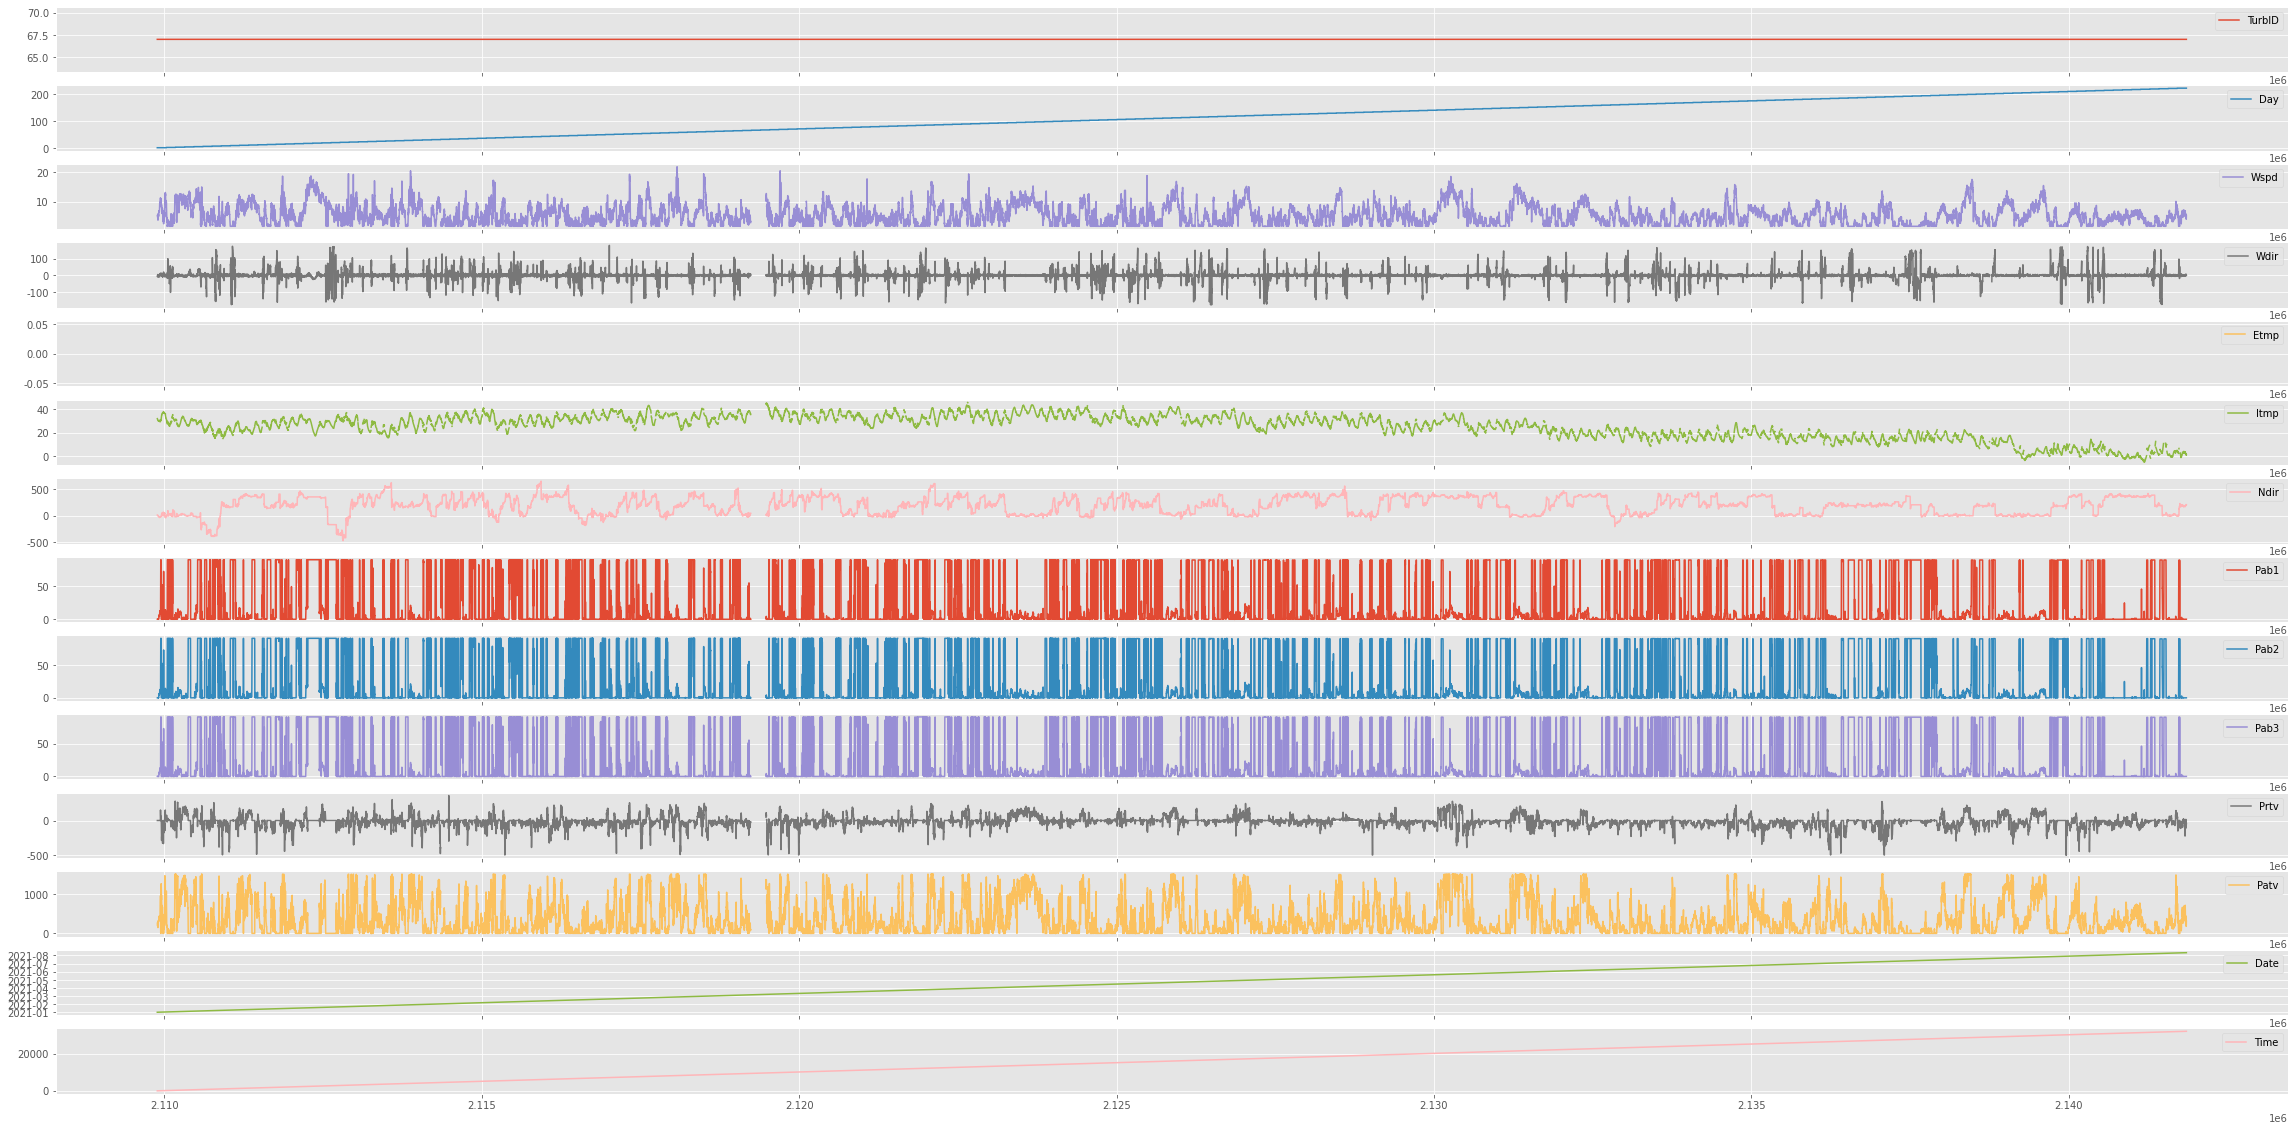

In [16]:
data4.query("TurbID == 67").plot(subplots=True, figsize=(40, 20));

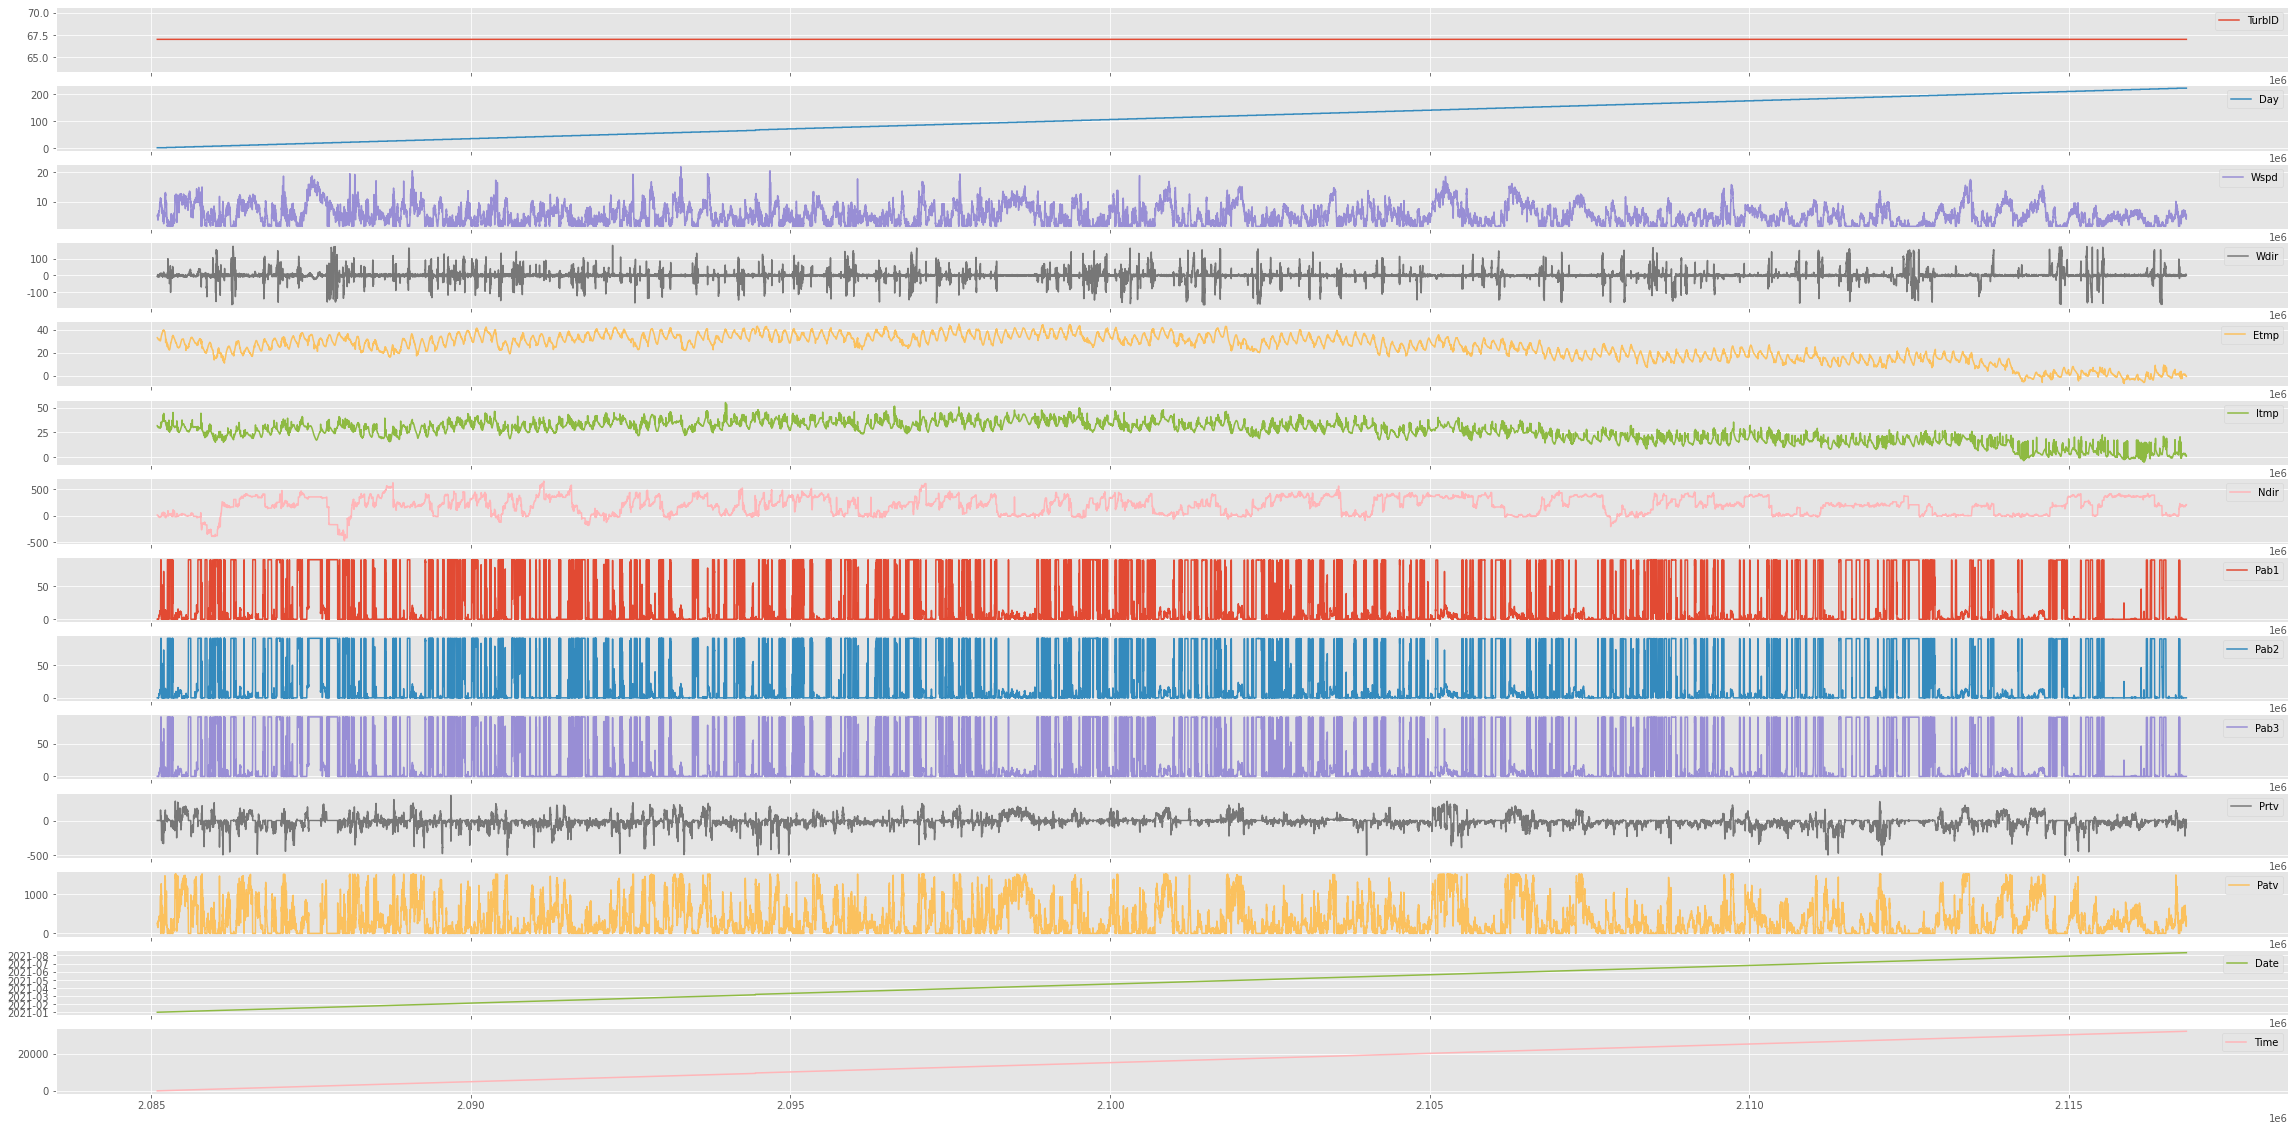

In [17]:
data5_gi.query("TurbID == 67").plot(subplots=True, figsize=(40, 20));